# Annual Sustainer Retention Cohort Grids

This project shows how many recurring donors' gifts are retained at multiple timepoints after their gifts started.

## Importing Packages

In [1]:
import civis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

client = civis.APIClient()
print(client.users.list_me()['username'])

penahoro


## Importing and Pre-Processing Dataset

In [2]:
#Importing dataset from RedShift
recur_donors = civis.io.read_civis('coc_reporting.recurring_donations_cohort_grid', 'TMC', use_pandas=True)
recur_donors.head()

#Converting to date-time columns for particular columns
recur_donors['date_gift_started'] = pd.to_datetime(recur_donors['date_gift_started'], errors='coerce')
recur_donors['gift_dates'] = pd.to_datetime(recur_donors['gift_dates'], errors='coerce')
recur_donors['CohortYear'] = recur_donors['date_gift_started'].dt.year
recur_donors['GiftYear'] = recur_donors['gift_dates'].dt.year

#Feature engineering for the cohort grid
recur_donors['CohortIndex']=recur_donors['GiftYear'] - recur_donors['CohortYear']

#Finding the number of people in each cohort. 
#One cohort in this context is made up of everyone who gave a recurring gift in a particular year. 
#So, for example, one cohort is made up of everyone who gave a recurring gift in 2013
#, another cohort is made up of everyone who gave a recurring gift in 2014 and so on.

people_per_cohort = recur_donors.groupby(['CohortYear'])['order_id'].nunique()
print(people_per_cohort)

CohortYear
2013       45
2014     1140
2015     1419
2016      878
2017     1906
2018     2095
2019      884
2020    25131
2021     3426
2022      277
Name: order_id, dtype: int64


## Finding the number of retained sustainers per year

In [3]:
#A sustainer is only counted as retained that year, if they gave in the last month of the year in consideration.

a= recur_donors.loc[(recur_donors['gift_dates'].dt.month == 12)  
                    
# Some quirks - some people give their last gift of the year on the last day in November, and still give in
# January of the next year - showing they were retained. This might be due to processing times. 
                    
                   | (recur_donors['gift_dates'].dt.month == 11) & (recur_donors['gift_dates'].dt.day == 30) 
                    
# If the year has not ended, based on cohorts, we include people who are still active i.e gave this month.
# For future iterations, you can replace the month with the month before this current month 
#(as you can expect to only see the true answer when a month has passed), and year with this current year.
                  
                    
                   | (recur_donors['gift_dates'].dt.month == 4) & (recur_donors['gift_dates'].dt.year == 2022)
                   ]

## Creating the cohort grid to show annual sustainer retention

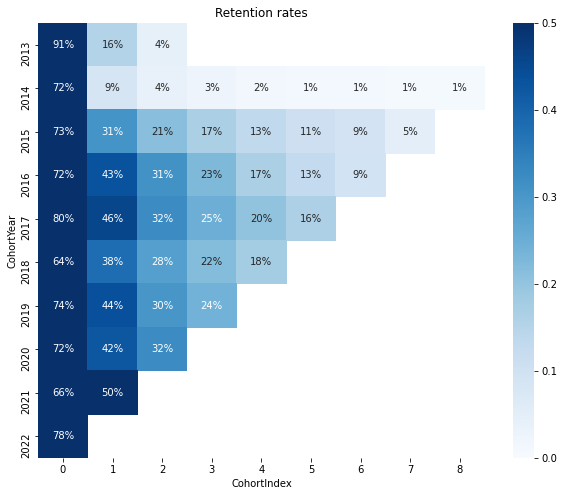

In [4]:
# Processing dataset
grouping = a.groupby(['CohortYear', 'CohortIndex'])
cohort_data = grouping['order_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortYear'
                                  ,columns='CohortIndex'
                                  ,values='order_id')

#Calculating retention
retention = cohort_counts.divide(people_per_cohort, axis=0)

#Plotting cohort grids
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention
            ,annot = True
            ,fmt = '.0%'
            ,vmin = 0.0
            ,vmax = 0.5
            ,cmap = 'Blues'
           )
plt.show()